# MLP MNIST

Vogliamo modellare un multi-layer perceptron utilizzando **Pytorch** per classificare il dataset MNIST.

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

from scipy.special import entr

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.1.post2 CUDA: False


## Dati
Vogliamo utilizzare il dataset MNIST, si può scaricare direttamente o caricarlo dai documenti.

In [3]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)


Vogliamo ora estrarre le prime tre classi in modo da fare il train solo su queste.

Inoltre dividiamo il dataset così creato in train (80%) e validate (20%)

In [92]:
split = int(np.floor(len(train_loader.dataset.train_labels))*0.8)

train_l = train_loader.dataset.train_labels[0:split]
train_d = train_loader.dataset.train_data[0:split]

val_l = train_loader.dataset.train_labels[split:-1]
val_d = train_loader.dataset.train_data[split:-1]

In [93]:
zeros = train_d[train_l == 0]
ones = train_d[train_l == 1]
twos = train_d[train_l == 2]


train_data012 = torch.cat([zeros, ones, twos])
train_labels012 = torch.cat([torch.zeros((len(zeros),)), torch.ones((len(ones),)), 2.0*torch.ones((len(twos),))])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
train_data012 = train_data012.type(torch.float32) / 255.0

print(len(train_data012))

14961


In [94]:
zeros = val_d[val_l == 0]
ones = val_d[val_l == 1]
twos = val_d[val_l == 2]


val_data012 = torch.cat([zeros, ones, twos])
val_labels012 = torch.cat([torch.zeros((len(zeros),)), torch.ones((len(ones),)), 2.0*torch.ones((len(twos),))])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
val_data012 = val_data012.type(torch.float32) / 255.0

print(len(val_data012))

3662


Adesso creiamo dei nuovi dataset per il train in modo da vedere come reagisce il classificatore con dati ID e OOD:

In [95]:
test_l012 = test_loader.dataset.test_labels
test_d012 = test_loader.dataset.test_data

zeros = test_d012[test_l012 == 0]
ones = test_d012[test_l012 == 1]
twos = test_d012[test_l012 == 2]


test_data012 = torch.cat([zeros, ones, twos])
test_labels012 = torch.cat([torch.zeros((len(zeros),)), torch.ones((len(ones),)), 2.0*torch.ones((len(twos),))])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
test_data012 = test_data012.type(torch.float32) / 255.0
print(len(test_data012))

3147


In [96]:
test_l = test_loader.dataset.test_labels
test_d = test_loader.dataset.test_data

threes = test_d[test_l == 3]
fours = test_d[test_l == 4]
fives = test_d[test_l == 5]

test_data345 = torch.cat([threes, fours, fives])
test_labels345 = torch.cat([torch.zeros((len(threes),)), torch.ones((len(fours),)), 2.0*torch.ones((len(fives),))])
#test_labels345 = torch.cat([3.0*torch.ones((len(threes),)), 4.0*torch.ones((len(fours),)), 5.0*torch.ones((len(fives),))])

# ADB: Qui ho notato che c'e' un problema: le immagini sono int8, ma devono essere float32.
# Faccio la conversione e divido per 255.0 (cosi' i pixel sono fra 0.0 e 1.0).
test_data345 = test_data345.type(torch.float32) / 255.0
print(len(test_data345))

2884


Adesso possiamo utilizzare i nuovi dataset creati per train, validation e test.

In [97]:

# Train012 80%
train_ds012 = TensorDataset(train_data012, train_labels012)
train_loader012 = torch.utils.data.DataLoader(train_ds012, batch_size=batch_size, shuffle=True, **kwargs)

# Validation012 20%
validation_ds012 = TensorDataset(val_data012, val_labels012)
validation_loader012 = torch.utils.data.DataLoader(validation_ds012, batch_size=batch_size, shuffle=True, **kwargs)

# Test012 all
test_ds012 = TensorDataset(test_data012, test_labels012)
test_loader012 = torch.utils.data.DataLoader(test_ds012, batch_size=batch_size, shuffle=True, **kwargs)

# Test345 all
test_ds345 = TensorDataset(test_data345, test_labels345)
test_loader345 = torch.utils.data.DataLoader(test_ds345, batch_size=batch_size, shuffle=True, **kwargs)

## ADB: Osservazioni

- Dati IN DISTRIBUTION per training (il train_loader012 va bene per questo). 
- Dati IN DISTRIBUTION per validation (i.e. per monitorare quanto bene classifichiamo le classi IN DISTRIBUTION). NON abbiamo questi data per la validation per ora.  
- Dati OUT OF DISTRIBUTION (OOD) per i test finali (questo abbiamo, ma abbiamo chiamato 'validation'). Non possiamo usare questi dati nella funzione validate() sotto, per esempio, perche' non abbiamo ettichette e perche' non sono IN DISTRIBUTION. 


## Prove

1) Proviamo a stampare le prime 10 immagini del train:

In [98]:
# ADB: qui ho modificato perche' ora ogni batch contiene un gruppo di immagini e anche un gruppo di label.
for (X_train, y_train) in train_loader012:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.FloatTensor


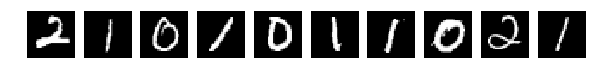

In [99]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :].numpy().reshape(28,28), cmap="gray")

2) Proviamo a stampare le prime 10 immagini del validation:

In [100]:
for (V_train, y_train) in validation_loader012:
    print('V_train:', V_train.size(), 'type:', V_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

V_train: torch.Size([32, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.FloatTensor


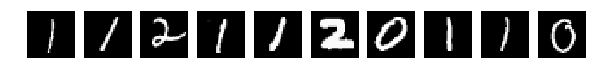

In [101]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(V_train[i, :, :].numpy().reshape(28,28), cmap="gray")

3) Proviamo a stampare le prime 10 immagini del test:

In [102]:
for (T_train, y_train) in test_loader012:
    print('T_train:', T_train.size(), 'type:', T_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

T_train: torch.Size([32, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.FloatTensor


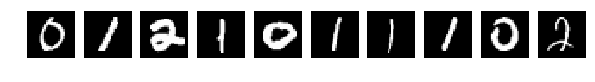

In [103]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(T_train[i, :, :].numpy().reshape(28,28), cmap="gray")

In [104]:
for (three_test, Y_train) in test_loader345:
    print('three_train:', three_test.size(), 'type:', three_test.type())
    print('Y_train:', Y_train.size(), 'type:', Y_train.type())
    break

three_train: torch.Size([32, 28, 28]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.FloatTensor


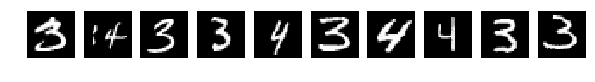

In [105]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(three_test[i, :, :].numpy().reshape(28,28), cmap="gray")

# Multi-layer Perceptron
Definiamo ora la rete neurale come una Python class.

In [106]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 3)     # Numero di output 3.

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

print(model)


Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)


Definiamo le funzioni di **train** e **test**

In [107]:
#----con l'entropia
#import torch.optim as optim
#criterion = nn.CrossEntropyLoss()

def train(epoch, log_interval, loader):
    model.train()
    batch_idx = 0
    while(batch_idx != len(loader)):
        for (data, target) in loader:
            target = target.type(torch.long)
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            #loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(loader.dataset),
                    100. * batch_idx / len(loader), loss.item()))
            batch_idx = batch_idx + 1

In [108]:
def validate(loss_vector, accuracy_vector, loader):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))

In [167]:
## Addestramento della rete su dataset012 con 3 epoche
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, 100, train_loader012)
    validate(lossv, accv, test_loader012)

Train Epoch: 1 [0/14961 (0%)]	Loss: 0.017142
Train Epoch: 1 [3200/14961 (21%)]	Loss: 0.027966
Train Epoch: 1 [6400/14961 (43%)]	Loss: 0.001047
Train Epoch: 1 [9600/14961 (64%)]	Loss: 0.066487
Train Epoch: 1 [12800/14961 (85%)]	Loss: 0.001363

Validation set: Average loss: 0.0196, Accuracy: 3124/3147 (99%)

Train Epoch: 2 [0/14961 (0%)]	Loss: 0.004891
Train Epoch: 2 [3200/14961 (21%)]	Loss: 0.007335
Train Epoch: 2 [6400/14961 (43%)]	Loss: 0.003205
Train Epoch: 2 [9600/14961 (64%)]	Loss: 0.002903
Train Epoch: 2 [12800/14961 (85%)]	Loss: 0.027816

Validation set: Average loss: 0.0168, Accuracy: 3129/3147 (99%)

Train Epoch: 3 [0/14961 (0%)]	Loss: 0.028372
Train Epoch: 3 [3200/14961 (21%)]	Loss: 0.009694
Train Epoch: 3 [6400/14961 (43%)]	Loss: 0.004612
Train Epoch: 3 [9600/14961 (64%)]	Loss: 0.001076
Train Epoch: 3 [12800/14961 (85%)]	Loss: 0.010216

Validation set: Average loss: 0.0179, Accuracy: 3126/3147 (99%)

Train Epoch: 4 [0/14961 (0%)]	Loss: 0.002990
Train Epoch: 4 [3200/14961 (21%

Possiamo adesso addestrare il nostro modello, ogni epoca passa attraverso tutto il dataset del train. Dopo ogni epoca valutiamo il modello attraverso il test(). L'obiettivo è verificare che il modello riconosca come 0, 1, 2 anche le immagini di 3, 4, 5 quindi la classificazione è **out of distribution**. Per farlo addestriamo la rete sul data012 e testiamo la precisione dei test sia su 012 che su 345 utilizzando avarage_precision_score.

## Test eseguiti con probabilità massima 

In [168]:
def max_test(epoch, loader):
    model.eval ()
    test_loss = 0
    correct = 0
    preds_list = []
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        output = model(data)
        preds_list.append(output)
        test_loss += F.nll_loss (output, target).item ()  # sum up batch loss
        pred = output.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    max_pred = new_predict(preds_list)
    test_loss /= len (loader.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (loader.dataset),
        100. * correct / len (loader.dataset)))
    return max_pred

In [169]:
###### rifaccio funzione predict che prende gli output di test li mette in numpy come matrice
def new_predict(preds_list):
    preds_list = torch.cat(preds_list)
    preds_list = torch.exp(preds_list)
    preds_list = preds_list.detach()
    preds_list = preds_list.numpy()
    preds_list = np.matrix(preds_list)
    print('\nLe probabilità di classificazione sono: ')
    print(preds_list)
    print('')
    idness = np.max(preds_list, 1)
    print ('\nLa max probabilità è: ')
    print(idness)
    return idness

In [170]:
def plot_func(y_true, y_scores, AP):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    return plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(AP))

In [171]:
def experiment_func(choosing_test):
    test = choosing_test
    ## Test_loader012
    print('\nTEST DATASET 012')
    result_ID = test(epoch, test_loader012)
    len_ID = len(result_ID)

    resID = np.empty((0, len_ID))
    for i in range (0, len_ID):
        newvalue = result_ID[i]
        resID = np.append(resID, newvalue)

    ## Test_loader345
    print('\nTEST DATASET 345')
    result_OOD = test(epoch, test_loader345)
    len_OOD = len(result_OOD)

    resOOD = np.empty((0, len_OOD))
    for i in range (0, len_OOD):
        newvalue = result_OOD[i]
        resOOD = np.append(resOOD, newvalue) 

    ## Raccolgo le predizioni max o con entropia in y_scores
    y_scores =np.concatenate((resID, resOOD), axis = None)
    print(y_scores)

    pred_ID = np.ones(len_ID, dtype=int)
    pred_OOD = np.zeros(len_OOD, dtype=int)

    ## Raccolgo le etichette, agli inD assegno 1, agli outD assegno 0
    y_true = np.concatenate((pred_ID, pred_OOD), axis = None)

    AP = average_precision_score(y_true, y_scores)

    print('L Avarage Precision è: ', AP)

    plot_func(y_true, y_scores, AP)
    
    return AP


TEST DATASET 012

Le probabilità di classificazione sono: 
[[2.2622035e-06 2.6220558e-04 9.9973541e-01]
 [5.2772957e-06 1.2230114e-05 9.9998236e-01]
 [9.9914396e-01 1.7908649e-04 6.7701750e-04]
 ...
 [1.2089819e-05 9.9993038e-01 5.7495850e-05]
 [2.4233266e-06 9.9998760e-01 1.0380157e-05]
 [1.0000000e+00 5.0456259e-13 1.9552175e-08]]


La max probabilità è: 
[[0.9997354 ]
 [0.99998236]
 [0.99914396]
 ...
 [0.9999304 ]
 [0.9999876 ]
 [1.        ]]

Test set: Average loss: 0.0005, Accuracy: 3129/3147 (99%)


TEST DATASET 345

Le probabilità di classificazione sono: 
[[2.3413652e-03 3.8959038e-02 9.5869964e-01]
 [3.2230376e-03 4.4238648e-01 5.5439043e-01]
 [1.5563564e-02 6.8933493e-01 2.9510149e-01]
 ...
 [3.7991378e-01 4.1877416e-01 2.0131201e-01]
 [4.8006657e-03 9.1703952e-04 9.9428242e-01]
 [3.6944148e-05 9.5472358e-05 9.9986744e-01]]


La max probabilità è: 
[[0.95869964]
 [0.55439043]
 [0.6893349 ]
 ...
 [0.41877416]
 [0.9942824 ]
 [0.99986744]]

Test set: Average loss: 0.1900, Accur

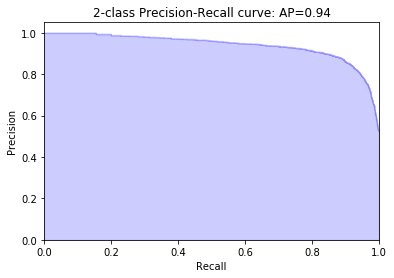

In [172]:
max_AP = experiment_func(max_test)

## Test eseguiti con entropia

In [173]:
def en_test(epoch, loader):
    model.eval ()
    test_loss = 0
    correct = 0
    preds_list = []
    for data, target in loader:
        target = target.type(torch.long)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data = Variable(data)
        target = Variable(target)
        output = model(data)
        preds_list.append(output)
        test_loss += F.nll_loss (output, target).item ()  # sum up batch loss
        pred = output.max (1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq (target.view_as (pred)).sum ().item ()
    ent_pred = predict_entropy(preds_list)
    test_loss /= len (loader.dataset)
    print ('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format (
        test_loss, correct, len (loader.dataset),
        100. * correct / len (loader.dataset)))
    return ent_pred

In [174]:
def predict_entropy(preds_list):
    preds_list = torch.cat(preds_list)
    preds_list = torch.exp(preds_list)
    preds_list = preds_list.detach()
    preds_list = preds_list.numpy()
    preds_list = np.matrix(preds_list)
    print('\nLe probabilità di classificazione sono: ')
    print(preds_list)
    print('')
    entropy = (-entr(preds_list)).sum(1)
    print('\nL entropia di ciascuna tripletta è: ')
    print(entropy)
    return entropy


TEST DATASET 012

Le probabilità di classificazione sono: 
[[1.1952347e-08 1.0397677e-08 1.0000000e+00]
 [5.5797028e-07 9.9999523e-01 4.2001184e-06]
 [2.5006170e-07 9.9999809e-01 1.6374591e-06]
 ...
 [3.4976011e-07 3.8841619e-05 9.9996090e-01]
 [1.1134387e-06 9.9998379e-01 1.5425998e-05]
 [5.5659675e-06 6.0387933e-06 9.9998856e-01]]


L entropia di ciascuna tripletta è: 
[[-4.0916558e-07]
 [-6.4801687e-05]
 [-2.7523503e-05]
 ...
 [-4.3877563e-04]
 [-2.0238708e-04]
 [-1.5135581e-04]]

Test set: Average loss: 0.0005, Accuracy: 3129/3147 (99%)


TEST DATASET 345

Le probabilità di classificazione sono: 
[[2.4775835e-04 3.9025301e-03 9.9584967e-01]
 [4.0786311e-01 7.1526569e-04 5.9142160e-01]
 [6.8056070e-05 9.3067908e-01 6.9252715e-02]
 ...
 [9.9926684e-03 1.3827058e-02 9.7618032e-01]
 [9.0509403e-01 4.4584827e-05 9.4861522e-02]
 [1.5233752e-02 1.8984078e-01 7.9492533e-01]]


L entropia di ciascuna tripletta è: 
[[-0.0278428 ]
 [-0.681592  ]
 [-0.25241798]
 ...
 [-0.12875439]
 [-0.314130

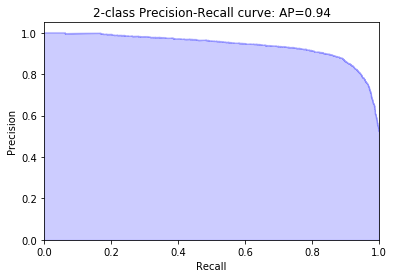

In [175]:
en_AP = experiment_func(en_test)

In [176]:
print('La differenza tra en_AP e max_AP è: ', en_AP - max_AP)

La differenza tra en_AP e max_AP è:  0.0005175425049959159
